#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

## Подготовка

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data = data.resample('1H').sum()

data.info()

## Анализ

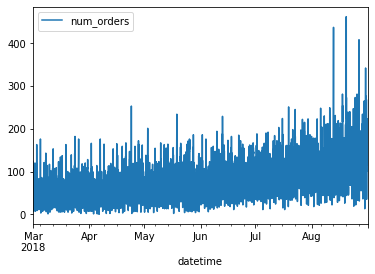

In [5]:
data.plot();

Проанализируем последний месяц.

In [6]:
decomposed = seasonal_decompose(data)

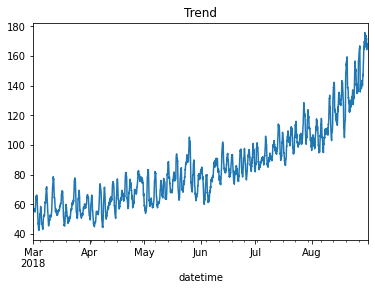

In [7]:
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend');

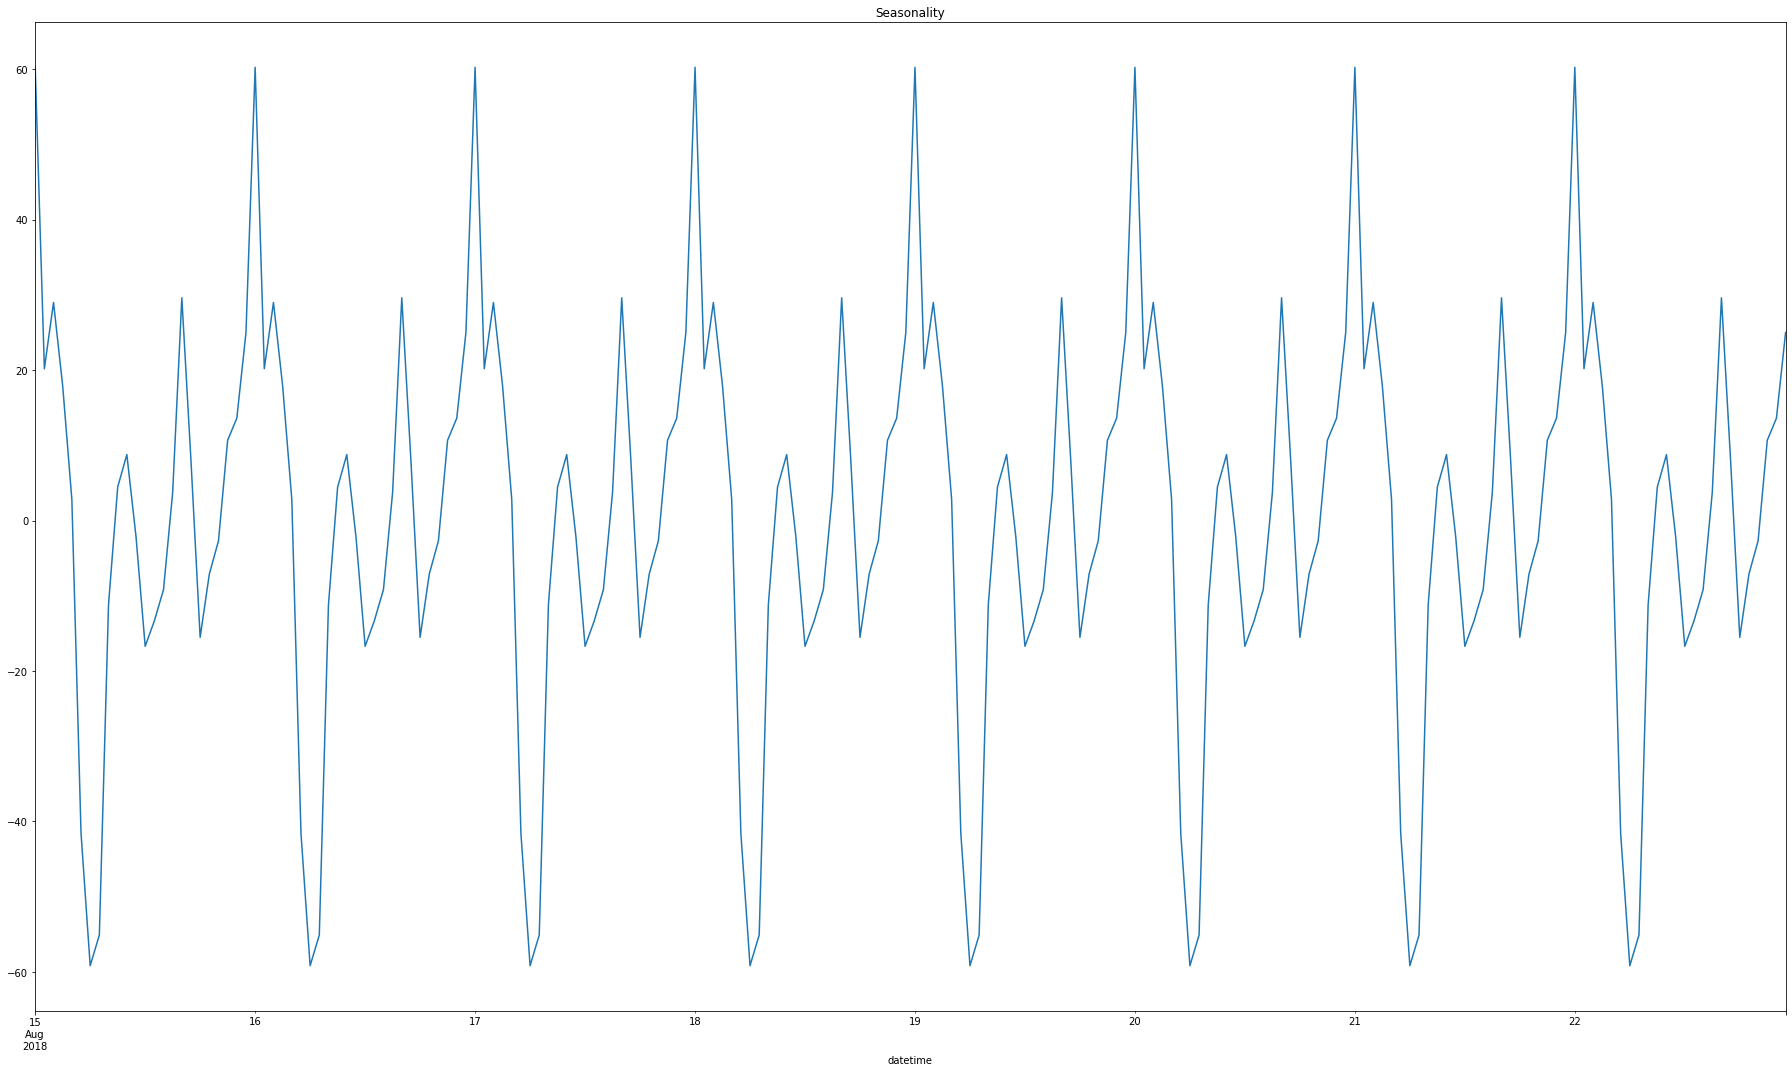

In [8]:
plt.figure(figsize=(25, 15))
decomposed.seasonal['2018-08-15':'2018-08-22'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.tight_layout()

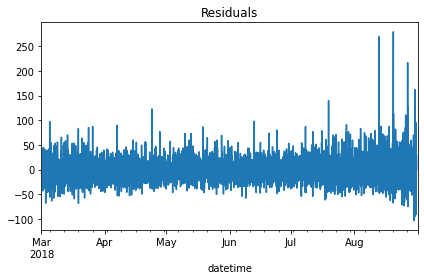

In [9]:
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Как мы видим по графику тренда, количество заказов растет со временем. Распределение сезонности статичное, ночью мало заказов, наибольшее количество к вечеру. По графику шумов видим почти всегда среднее значение, однако есть всплески, которые можно объяснить выходными и праздниками.

## Обучение

In [10]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [11]:
make_features(data, 24, 24)

In [12]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=12345)

In [14]:
train = train.dropna()

In [15]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [16]:
features_train.shape

(3950, 27)

In [17]:
len(target_train)

3950

In [18]:
features_train.shape

(3950, 27)

In [19]:
len(target_test)

442

In [20]:
features_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,43.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [21]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scal = pd.DataFrame(scaler.transform(features_train))

Обучим линейную регрессию.

In [22]:
model_lin = LinearRegression()
tscv = TimeSeriesSplit(n_splits=3)
m_l = GridSearchCV(estimator=model_lin, param_grid={}, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
m_l.fit(features_train_scal, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ................................., score=-24.920 total time=   0.0s
[CV 2/3] END ................................., score=-26.135 total time=   0.1s
[CV 3/3] END ................................., score=-32.264 total time=   0.3s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(), param_grid={},
             scoring='neg_root_mean_squared_error', verbose=3)

In [23]:
m_l.best_estimator_

LinearRegression()

In [24]:
m_l.best_score_

-27.772949148293964

Обучим лес.

In [25]:
model_forest = RandomForestRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=3)
params = {'max_depth': range(5,10), 'n_estimators': range(25, 101, 25)}
m_f = GridSearchCV(estimator=model_forest, param_grid=params, scoring='neg_root_mean_squared_error', cv=tscv)
m_f.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': range(5, 10),
                         'n_estimators': range(25, 101, 25)},
             scoring='neg_root_mean_squared_error')

In [26]:
m_f.best_estimator_

RandomForestRegressor(max_depth=9, random_state=12345)

In [27]:
m_f.best_score_

-27.24125967718682

Обучим LightGBM.

In [28]:
model_lgb = lgb.LGBMRegressor(random_state=12345)
tscv = TimeSeriesSplit(n_splits=3)
m_lgb = GridSearchCV(estimator=model_lgb, param_grid={}, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
m_lgb.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ................................., score=-24.383 total time=  12.5s
[CV 2/3] END ................................., score=-24.284 total time=   6.8s
[CV 3/3] END ................................., score=-31.386 total time=   9.8s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(random_state=12345), param_grid={},
             scoring='neg_root_mean_squared_error', verbose=3)

In [29]:
m_lgb.best_score_

-26.684675194548007

И наконец CatBoost.

In [30]:
model_cat = CatBoostRegressor(loss_function="RMSE", verbose=False, random_state=12345)
tscv = TimeSeriesSplit(n_splits=3)
m_cat = GridSearchCV(estimator=model_cat, param_grid={}, scoring='neg_root_mean_squared_error', cv=tscv, verbose=3)
m_cat.fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ................................., score=-23.453 total time=   4.2s
[CV 2/3] END ................................., score=-23.474 total time=   5.0s
[CV 3/3] END ................................., score=-30.534 total time=   5.4s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f4cb46b0b50>,
             param_grid={}, scoring='neg_root_mean_squared_error', verbose=3)

In [31]:
m_cat.best_score_

-25.820281366648782

Для всех моделей получили RMSE < 48, что удовлетворяет условию задачи. На всех моделях RMSE примерно равный.

## Тестирование

Проверим RMSE на лучшей модели CatBoost.

In [32]:
predictions_cat = m_cat.predict(features_test)
mean_squared_error(target_test, predictions_cat)**0.5

40.97105193240247

Получили удовлетворяющее нас RMSE < 48.